In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np

# Display plots inline
%matplotlib inline

# === CONFIGURATION ===
# Using relative paths assuming this notebook is in the project root
# Adjust these if your folder names differ
PATH_ROBUST = "./Results/simulation_results/aggregated/"
PATH_STANDARD = "./Results_StandardScaler/simulation_results/aggregated/"

# Methods to compare (Keys in the DataFrame columns)
METHODS_TO_COMPARE = ["WiGS (SAC)", "iGS"]

print("Configuration loaded.")
print(f"Robust Path: {os.path.abspath(PATH_ROBUST)}")
print(f"Standard Path: {os.path.abspath(PATH_STANDARD)}")

Configuration loaded.
Robust Path: /mnt/beegfs/homes/simondn/WeightedGreedySampling/Results/simulation_results/aggregated
Standard Path: /mnt/beegfs/homes/simondn/WeightedGreedySampling/Results_StandardScaler/simulation_results/aggregated


In [2]:
def load_rmse_data(base_path, dataset_name):
    """Loads the RMSE.pkl dataframe for a given dataset."""
    file_path = os.path.join(base_path, dataset_name, "full_pool_metrics", "RMSE.pkl")
    
    if not os.path.exists(file_path):
        return None
    
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        # === FIX: Handle Dictionary of DataFrames ===
        if isinstance(data, dict):
            # The structure is { "MethodName": DataFrame(Sim_0, Sim_1...) }
            # We want to calculate the MEAN across simulations for each method
            method_means = {}
            
            for method_name, method_df in data.items():
                if isinstance(method_df, pd.DataFrame):
                    # Average across columns (Simulations) to get the mean curve
                    # Skip NA values just in case
                    method_means[method_name] = method_df.mean(axis=1)
                else:
                    print(f"Warning: Expected DataFrame for {method_name} in {dataset_name}, got {type(method_df)}")

            # Combine all method means into a single DataFrame
            df = pd.DataFrame(method_means)
            return df
        # ============================================

        # Fallback for old structure (just in case)
        if isinstance(data, pd.DataFrame):
             if isinstance(data.columns, pd.MultiIndex):
                return data.groupby(level=0, axis=1).mean()
             return data
            
        return None

    except Exception as e:
        print(f"Error loading {dataset_name}: {e}")
        return None

Found 20 common datasets.


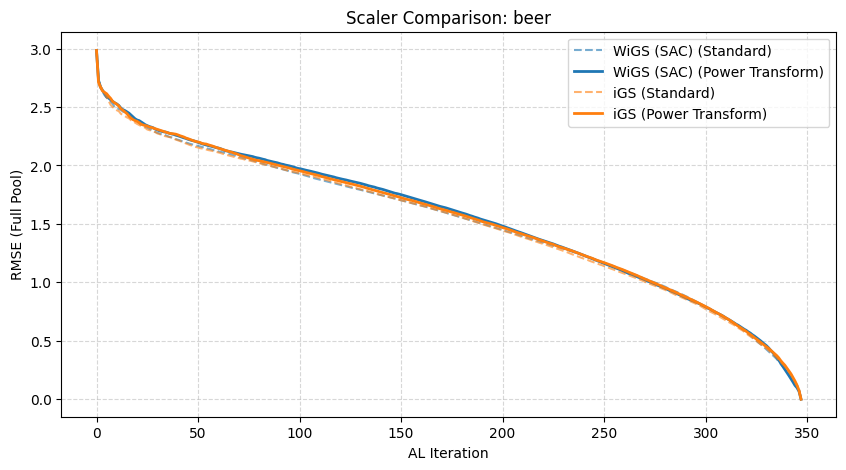

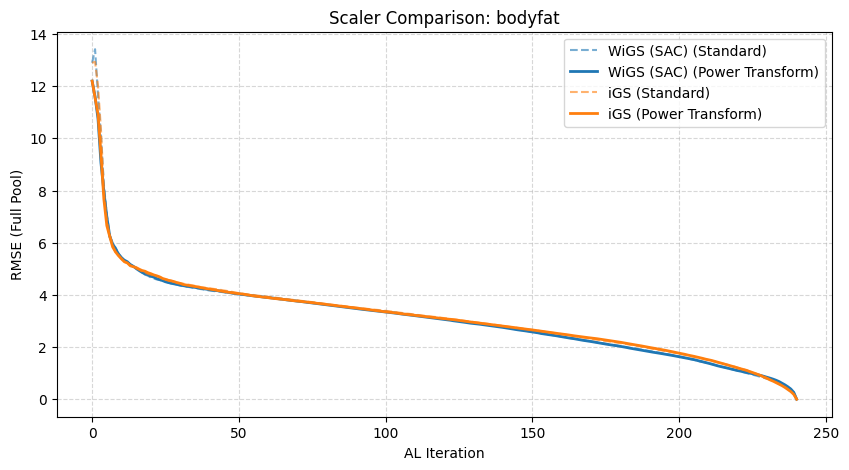

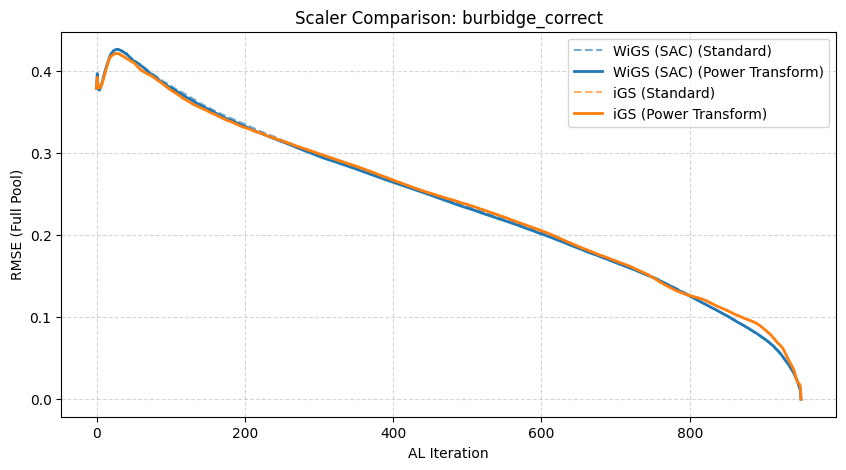

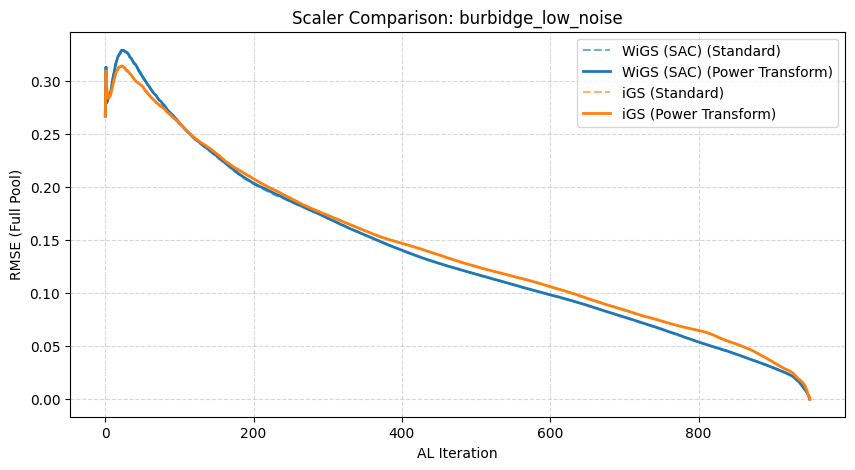

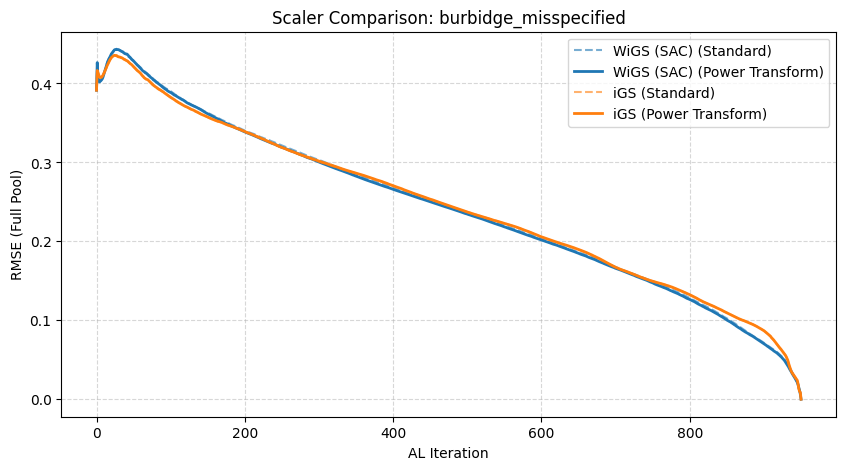

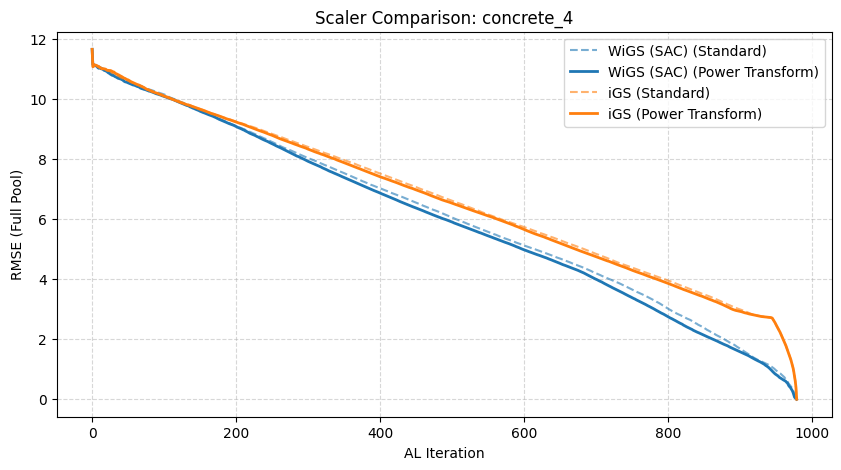

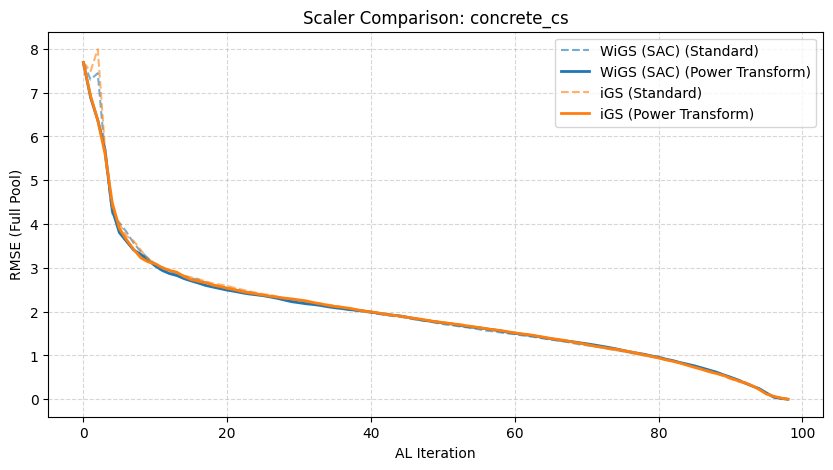

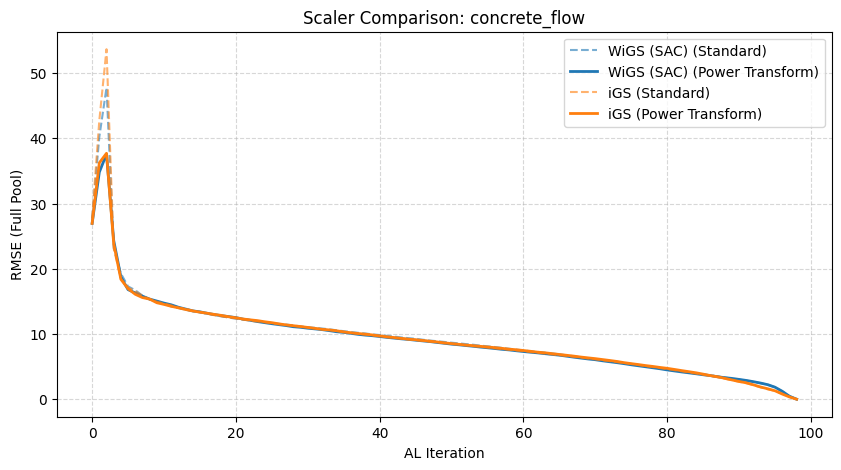

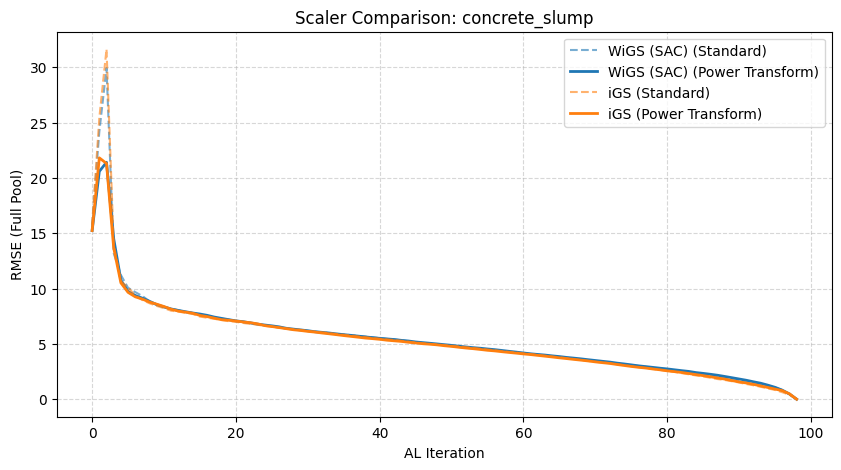

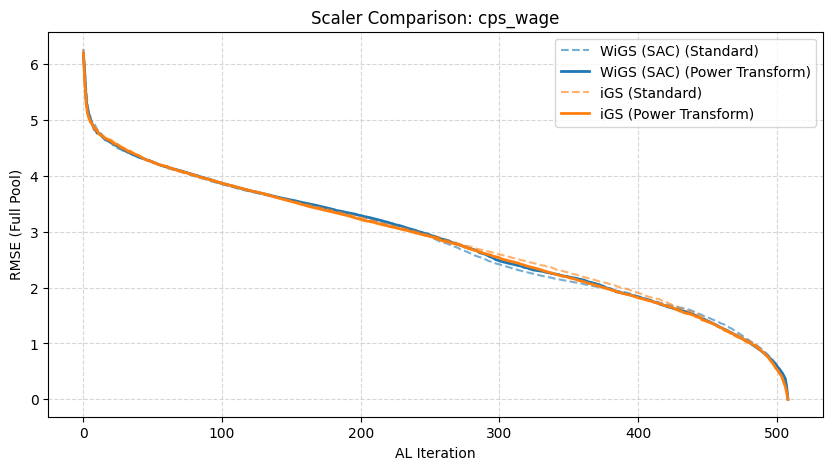

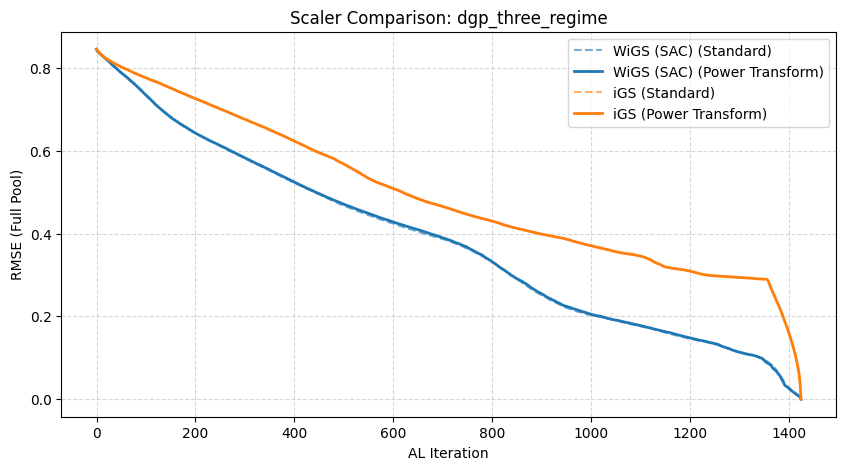

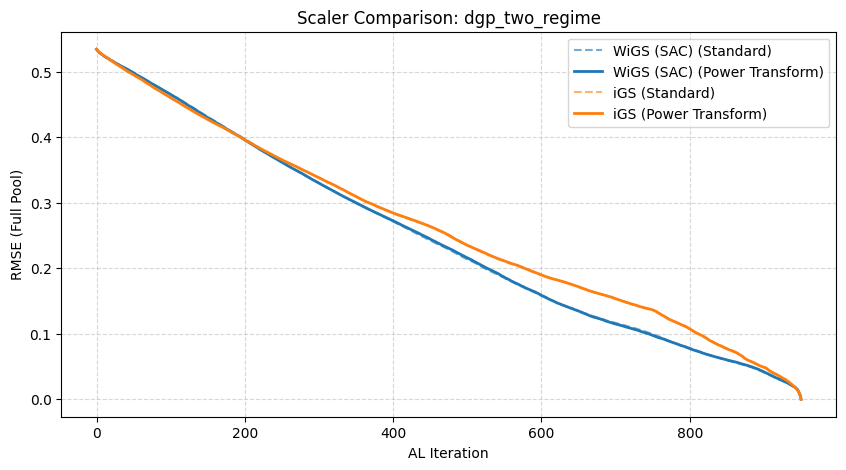

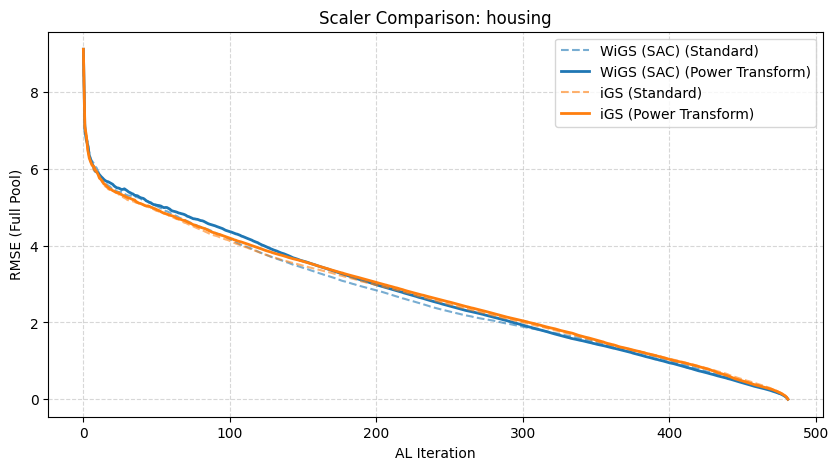

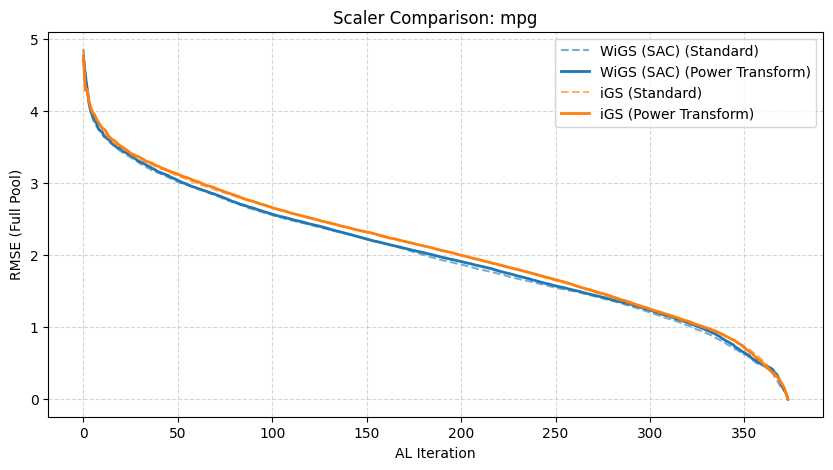

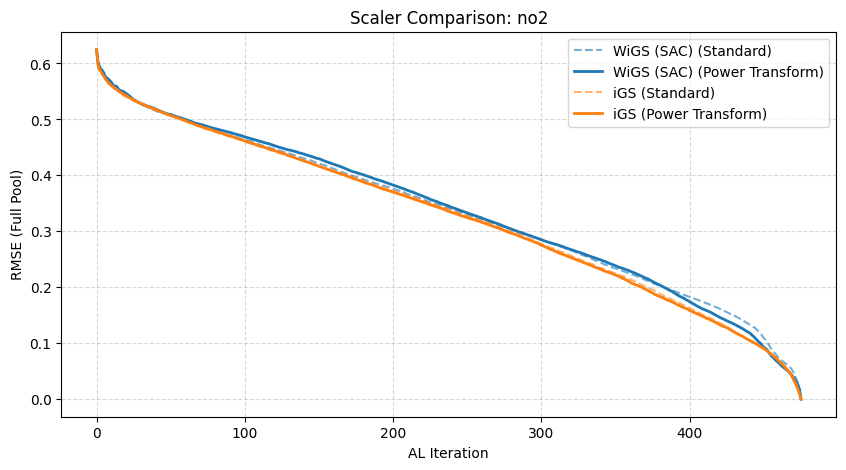

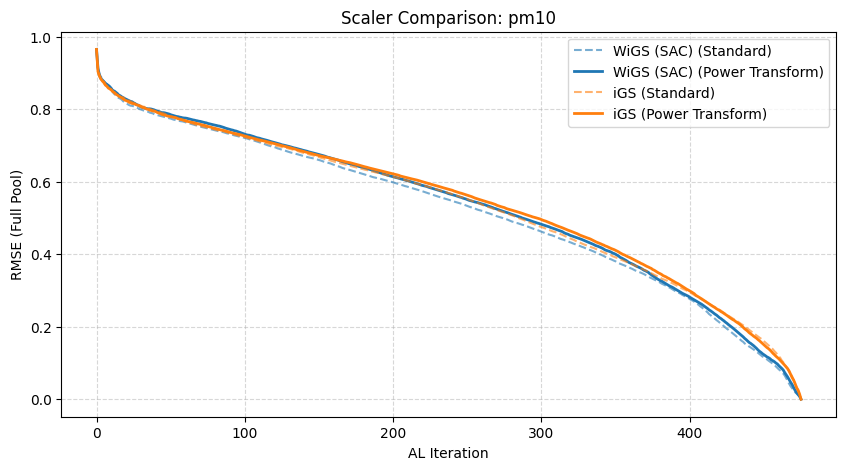

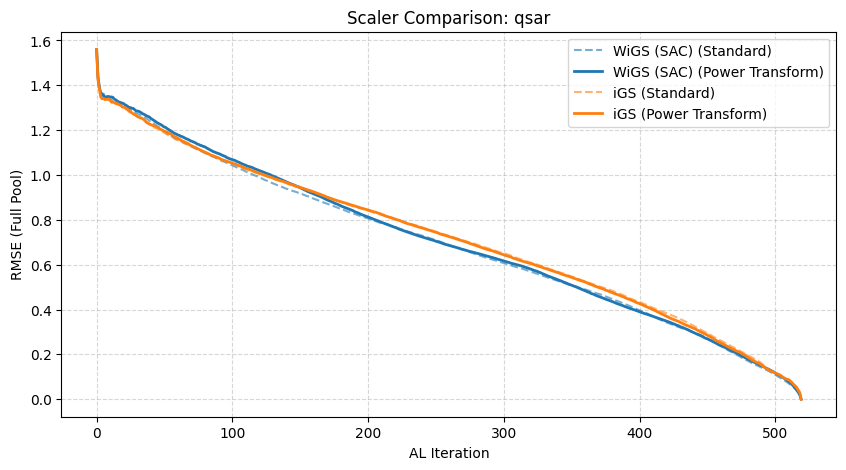

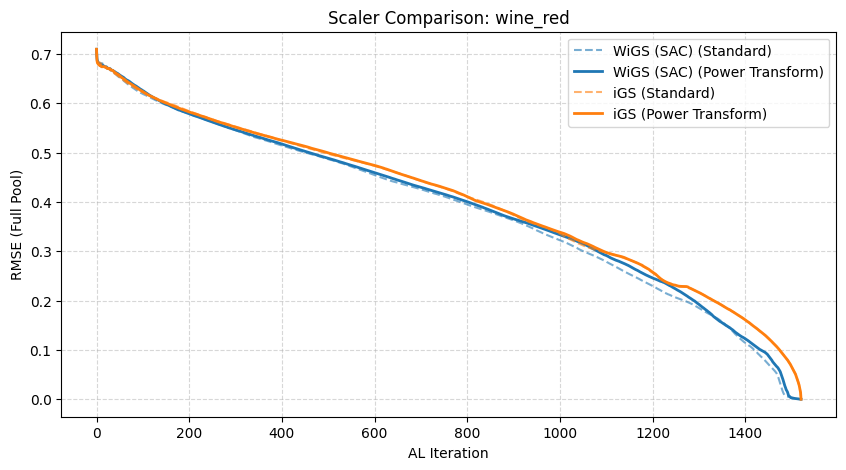

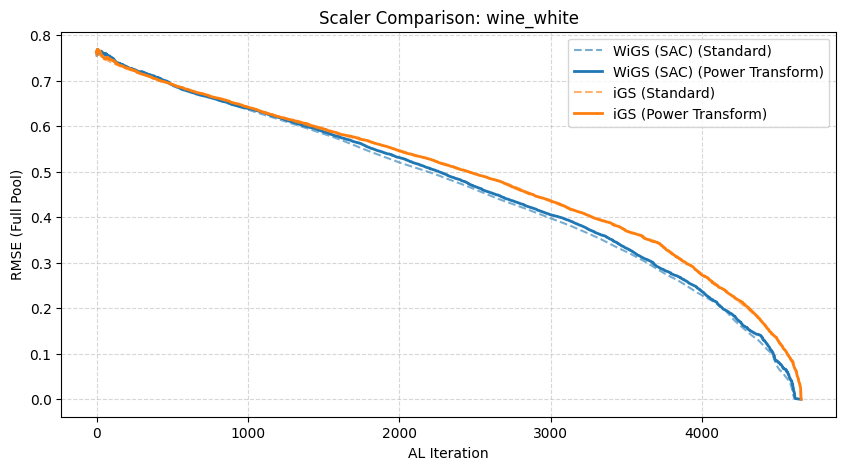

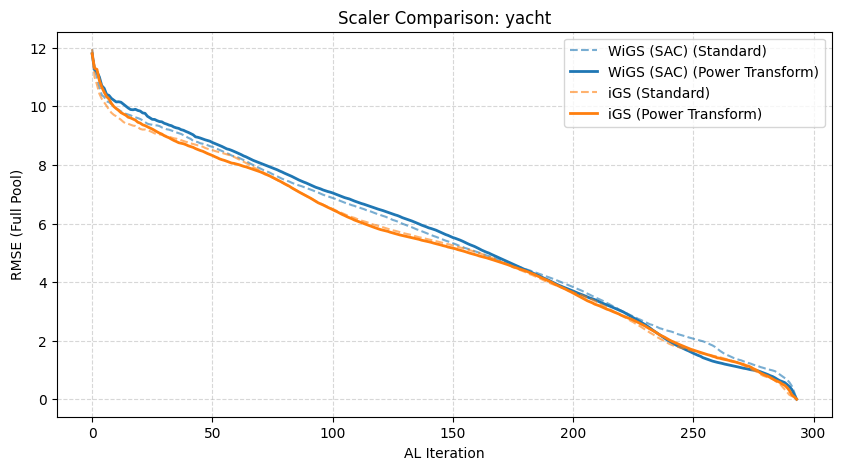

In [3]:
# 1. Get list of common datasets
if not os.path.exists(PATH_ROBUST) or not os.path.exists(PATH_STANDARD):
    print("Error: One of the paths does not exist. Check your directories.")
else:
    datasets_robust = set(os.listdir(PATH_ROBUST))
    datasets_standard = set(os.listdir(PATH_STANDARD))
    common_datasets = sorted(list(datasets_robust.intersection(datasets_standard)))
    
    # Filter out hidden files
    common_datasets = [d for d in common_datasets if not d.startswith(".")]

    summary_data = []

    print(f"Found {len(common_datasets)} common datasets.")

    # === STYLE CONFIGURATION ===
    # Map methods to specific colors
    COLOR_MAP = {
        "WiGS (SAC)": "tab:blue",
        "iGS": "tab:orange"
    }

    # Loop through datasets
    for dataset in common_datasets:
        df_robust = load_rmse_data(PATH_ROBUST, dataset)
        df_standard = load_rmse_data(PATH_STANDARD, dataset)

        if df_robust is None or df_standard is None:
            continue

        # --- PLOTTING ---
        plt.figure(figsize=(10, 5))
        
        for method in METHODS_TO_COMPARE:
            color = COLOR_MAP.get(method, "gray") # Default to gray if unknown

            # 1. Plot Standard (Dashed)
            if method in df_standard.columns:
                plt.plot(df_standard.index, df_standard[method], 
                         color=color, linestyle='--', alpha=0.6, 
                         label=f"{method} (Standard)")

            # 2. Plot Robust (Solid)
            if method in df_robust.columns:
                plt.plot(df_robust.index, df_robust[method], 
                         color=color, linestyle='-', linewidth=2, 
                         label=f"{method} (Power Transform)")

        plt.title(f"Scaler Comparison: {dataset}")
        plt.xlabel("AL Iteration")
        plt.ylabel("RMSE (Full Pool)")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

        # --- SUMMARY STATS ---
        row = {"Dataset": dataset}
        for method in METHODS_TO_COMPARE:
            if method in df_robust.columns and method in df_standard.columns:
                final_robust = df_robust[method].iloc[-1]
                final_standard = df_standard[method].iloc[-1]
                diff = final_robust - final_standard 
                
                row[f"{method} Final (Rob)"] = final_robust
                row[f"{method} Final (Std)"] = final_standard
                row[f"{method} Diff"] = diff
        
        summary_data.append(row)